## Home Valuation Model

1. Which features of a home have the greatest positive impact on the home values?
2. Which features of a home have the least impact on the home values?
3. Which features could be discarded, saving on building costs?
4. Can we accurately predict home values given a set of home features?
5. Which model predicts home values most accurately?

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

### Import Modules/Packages

In [3]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
import pandas as pd
print('The pandas version is {}'.format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print('The matplotlib version is {}'.format(matplotlib.__version__))
import numpy as np
print('The numpy version is {}'.format(np.__version__))
import seaborn as sns

The scikit-learn version is 1.3.2.
The pandas version is 2.1.4
The matplotlib version is 3.8.2
The numpy version is 1.23.5


### Import Data (Train and Test)

In [4]:
df_house_train = pd.read_csv(
    r"train.csv",
    low_memory=False,
)

# drop columns with all NaN values
df_house_train.dropna(axis=1, how="all")

# limit to only residential properties
residential = ["FV", "RH", "RL", "RP", "RM"]
df_house_train = df_house_train[df_house_train["MSZoning"].isin(residential)]
print("Train Data Shape: ", df_house_train.shape)


Train Data Shape:  (1450, 81)


### Train Data Sample

In [5]:
df_house_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Summary & Findings

#### Missing Data

In [7]:
missing_values = df_house_train.select_dtypes(object).isna().sum()
print(missing_values[missing_values > 0])
print("Total number of missing values:", df_house_train.isna().sum().sum())


Alley           1361
MasVnrType       862
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64
Total number of missing values: 7767


In [8]:
# Fill missing data with zero

def fill_missing_data(df: pd.DataFrame):
    for col_ in df.columns:
        if df[col_].dtype == "object":
            # fill 'NONE' for categorical features
            df[col_].fillna("NONE", inplace=True)
        else:
            # fill zero for numerical features
            df[col_].fillna(0, inplace=True)


fill_missing_data(df_house_train)


#### Data Statistical Summary

In [9]:
df_house_train.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1450.000000,1450.000000,1450.00000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,57.54000,10523.831724,6.114483,5.582069,1971.593103,1985.049655,103.828276,445.162759,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069
std,421.554345,42.265033,34.71992,10012.185355,1.372860,1.107330,30.022696,20.552319,181.150114,456.353871,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241
min,1.000000,20.000000,0.00000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,366.250000,20.000000,41.25000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,731.500000,50.000000,63.00000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,1096.750000,70.000000,79.00000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.000000,713.750000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.00000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Data Information

In [10]:
df_house_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1450 non-null   int64  
 1   MSSubClass     1450 non-null   int64  
 2   MSZoning       1450 non-null   object 
 3   LotFrontage    1450 non-null   float64
 4   LotArea        1450 non-null   int64  
 5   Street         1450 non-null   object 
 6   Alley          1450 non-null   object 
 7   LotShape       1450 non-null   object 
 8   LandContour    1450 non-null   object 
 9   Utilities      1450 non-null   object 
 10  LotConfig      1450 non-null   object 
 11  LandSlope      1450 non-null   object 
 12  Neighborhood   1450 non-null   object 
 13  Condition1     1450 non-null   object 
 14  Condition2     1450 non-null   object 
 15  BldgType       1450 non-null   object 
 16  HouseStyle     1450 non-null   object 
 17  OverallQual    1450 non-null   int64  
 18  OverallCond  

#### Correlation by feature

In [11]:
# Select only numeric columns
numeric_columns = df_house_train.select_dtypes(include=['number']) 
    # would like to convert some of the object features in future

# Pairwise Pearson correlations for train set 
price_correlations = numeric_columns.corrwith(df_house_train["SalePrice"])
print(price_correlations)


Id              -0.024353
MSSubClass      -0.087487
LotFrontage      0.214273
LotArea          0.264715
OverallQual      0.789031
OverallCond     -0.089084
YearBuilt        0.517602
YearRemodAdd     0.501186
MasVnrArea       0.471056
BsmtFinSF1       0.384475
BsmtFinSF2      -0.014145
BsmtUnfSF        0.216152
TotalBsmtSF      0.612088
1stFlrSF         0.603300
2ndFlrSF         0.319774
LowQualFinSF    -0.018755
GrLivArea        0.708658
BsmtFullBath     0.224054
BsmtHalfBath    -0.017561
FullBath         0.556674
HalfBath         0.280882
BedroomAbvGr     0.162008
KitchenAbvGr    -0.137825
TotRmsAbvGrd     0.533355
Fireplaces       0.463264
GarageYrBlt      0.258923
GarageCars       0.642135
GarageArea       0.629831
WoodDeckSF       0.320770
OpenPorchSF      0.329491
EnclosedPorch   -0.120765
3SsnPorch        0.043807
ScreenPorch      0.110540
PoolArea         0.092396
MiscVal         -0.021052
MoSold           0.051987
YrSold          -0.025391
SalePrice        1.000000
dtype: float

### Data Visualization 

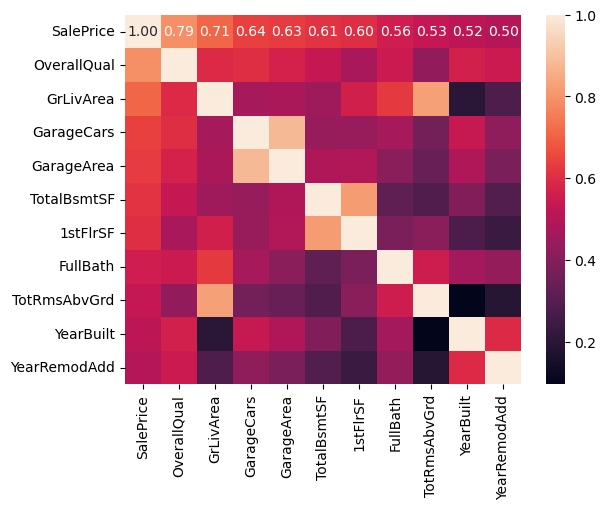

In [12]:
correlation = numeric_columns.corr()
top_10_corr = correlation.nlargest(11, "SalePrice")["SalePrice"].index
cm = np.corrcoef(numeric_columns[top_10_corr].values.T)
correlation_hm = sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=top_10_corr.values,
    xticklabels=top_10_corr.values,
)


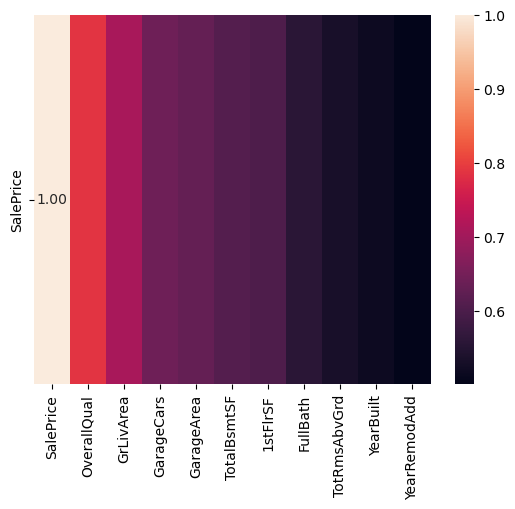

In [13]:
correlation = numeric_columns.corr().abs() # Get absolute value
top_10_corr = correlation.nlargest(11, "SalePrice")["SalePrice"].index
cm = np.corrcoef(numeric_columns[top_10_corr].values.T)
correlation_values = cm[top_10_corr == "SalePrice", :].reshape(1, -1)

correlation_hm = sns.heatmap(
    correlation_values,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=["SalePrice"],
    xticklabels=top_10_corr.values,
)

#### Building Type

Text(0.5, 1.0, 'BldgType')

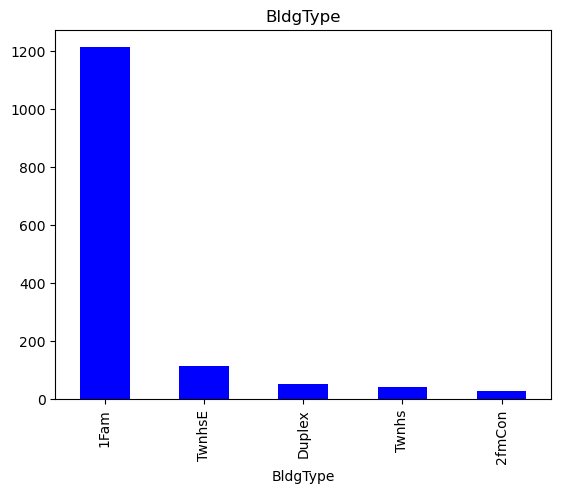

In [14]:
df_house_train["BldgType"].value_counts().head(10).plot(kind="bar", color="b")
plt.title("BldgType")


### Price vs. Sqft

#### All plots: Identifying Outliers

c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

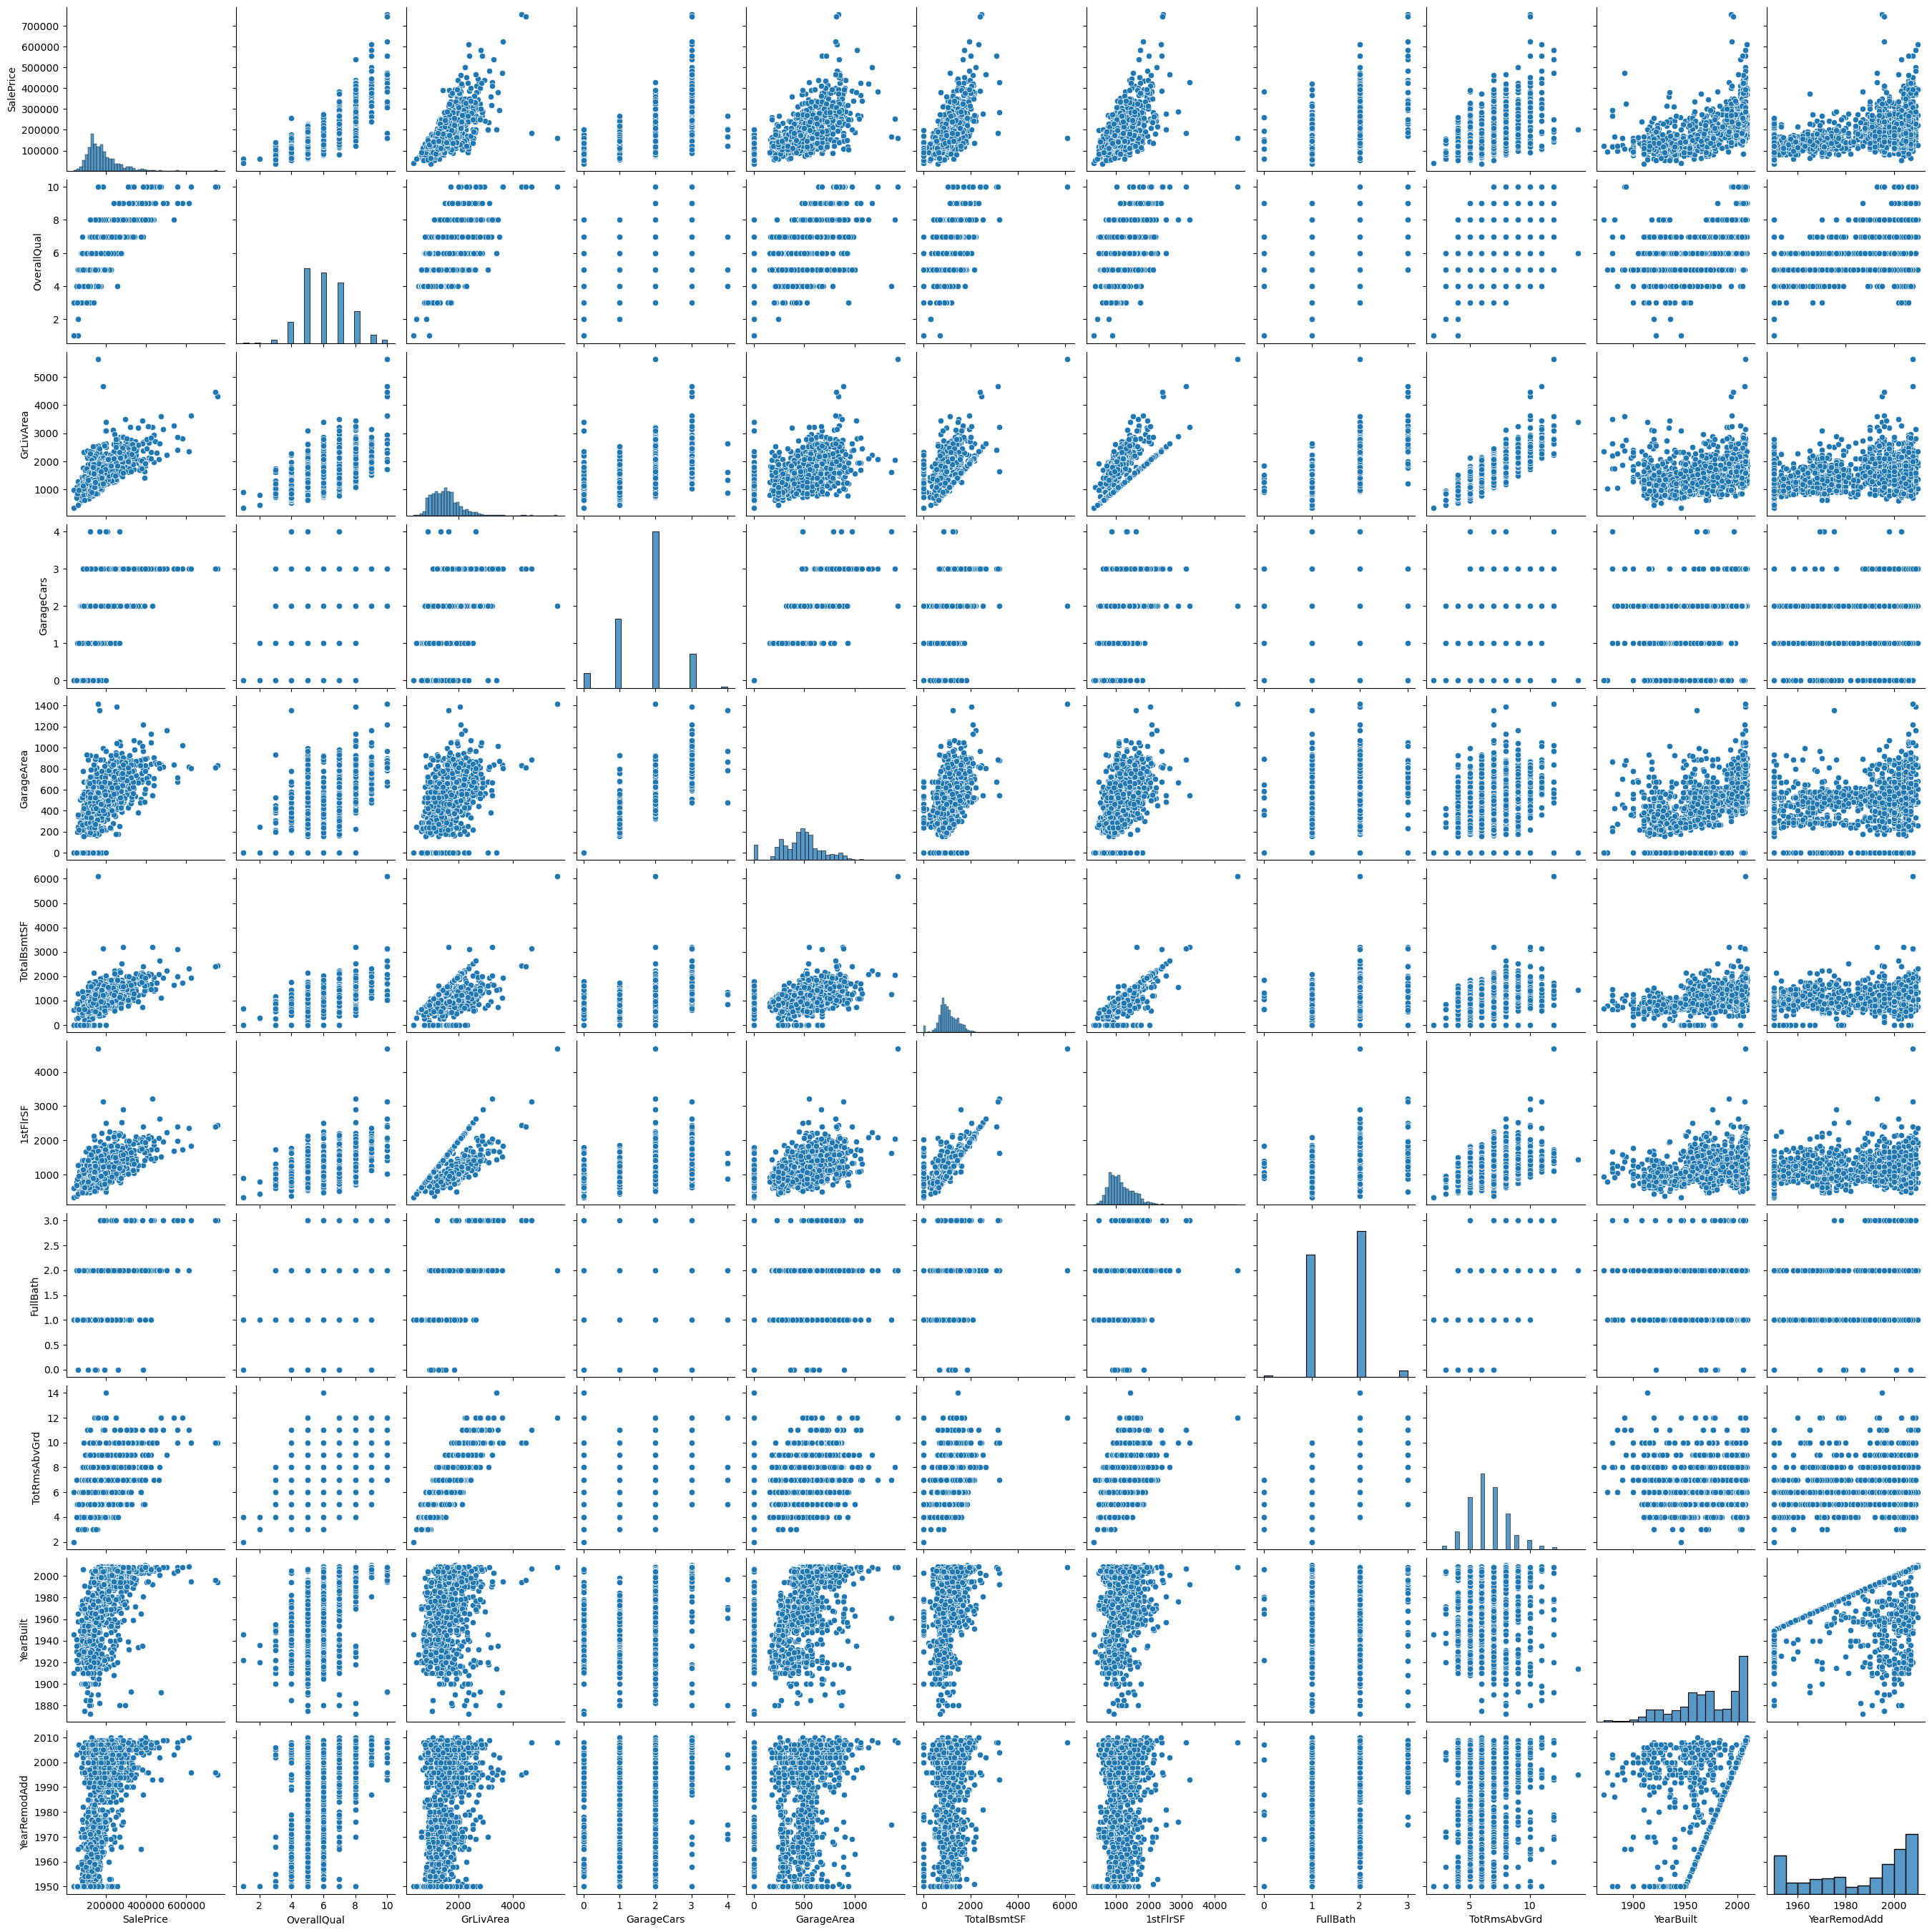

In [15]:
sns.pairplot(df_house_train[top_10_corr], height=2.5)


#### Remove Outliers

In [16]:
df_house_train = df_house_train[df_house_train.GrLivArea < 4400]
df_house_train = df_house_train[df_house_train.TotalBsmtSF < 2500]


### Sale Price

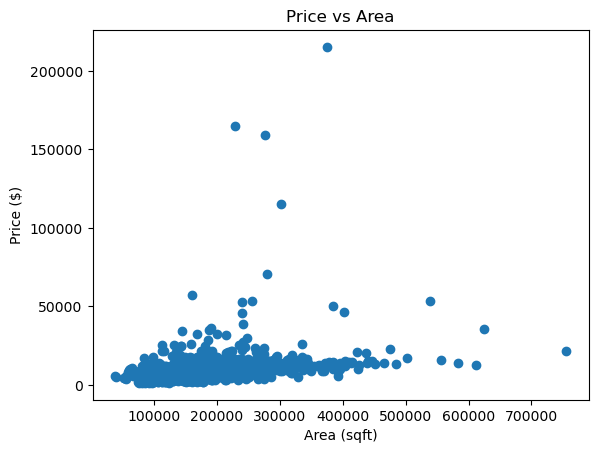

In [17]:
# plot a scatter plot price vs area
plt.scatter(df_house_train["SalePrice"], df_house_train["LotArea"])
# set axis lables
plt.xlabel("Area (sqft)")
plt.ylabel("Price ($)")
# set chart title
plt.title("Price vs Area")
plt.show()


In [18]:
# Average house price
print(
    "The average house price is", "${:,.2f}".format(df_house_train["SalePrice"].mean())
)


The average house price is $180,510.69


Skewness: 1.7427346139226505


c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Kurtosis: 5.493707388774607


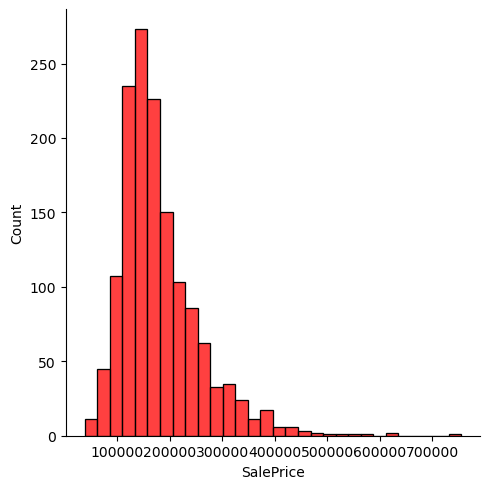

In [19]:
# Sale price histogram
sns.displot(df_house_train["SalePrice"], kde=False, color="red", bins=30)
print("Skewness:", df_house_train["SalePrice"].skew())
print("Kurtosis:", df_house_train["SalePrice"].kurt())


In [20]:
# Number of houses sold each year
ann_sales = (
    df_house_train.groupby(["YrSold"])["SalePrice"]
    .count()
    .reset_index(name="Count")
    .sort_values(["Count"], ascending=False)
)
print(ann_sales)


   YrSold  Count
3    2009    333
1    2007    324
0    2006    312
2    2008    301
4    2010    172


## Questions

### 1. Which features of a home have the greatest positive impact on the home values?

In [21]:
print("The Features with the greatest positive impact on home values are:")
print(top_10_corr)


The Features with the greatest positive impact on home values are:
Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


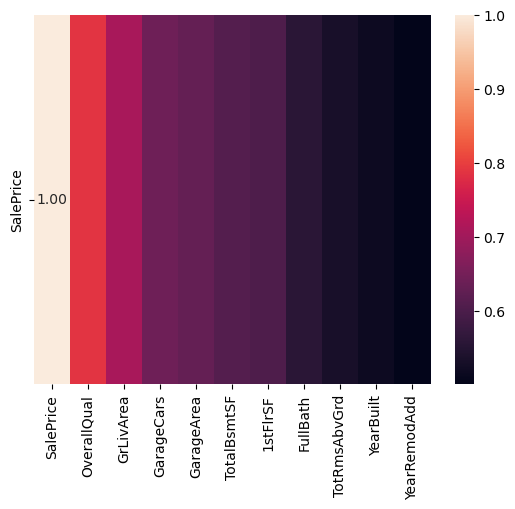

In [22]:
sales_correlation_hm = sns.heatmap(
    cm[:1],
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=top_10_corr[:1].values,
    xticklabels=top_10_corr.values,
)


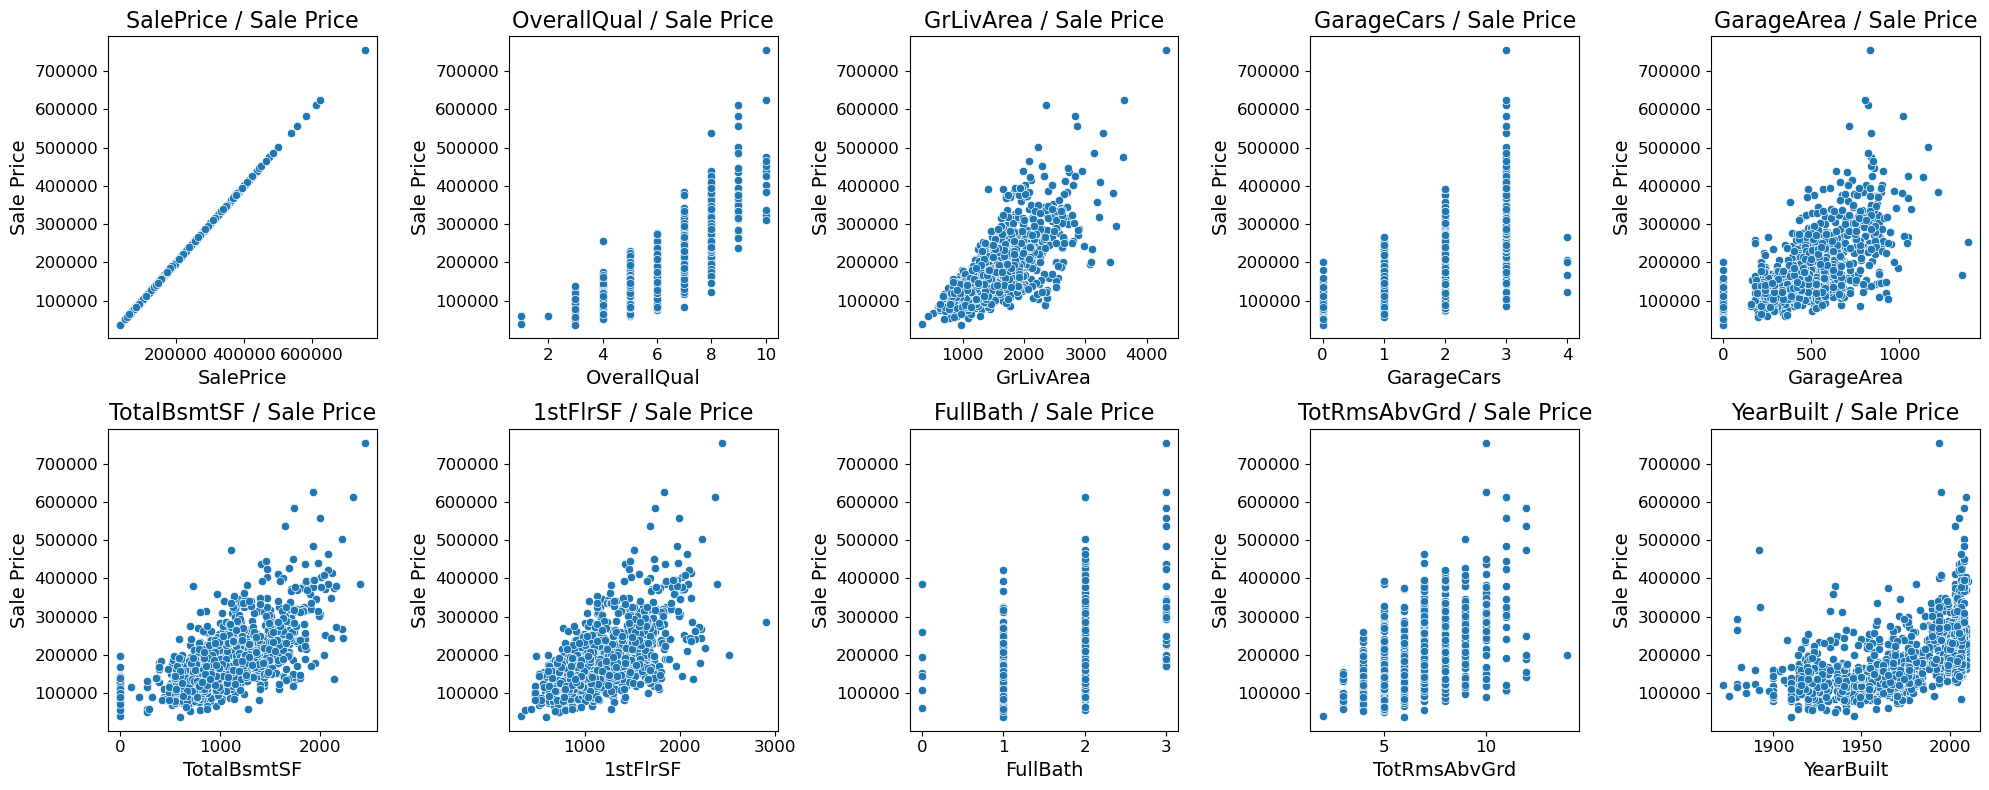

In [23]:
Positive_FEATURES = top_10_corr

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axs = axs.flatten()

for i, ax in enumerate(axs):
    sns.scatterplot(x=df_house_train[Positive_FEATURES[i]], y=df_house_train['SalePrice'], ax=ax)
    ax.set_title('{} / Sale Price'.format(Positive_FEATURES[i]), fontsize=16)
    ax.set_xlabel('{}'.format(Positive_FEATURES[i]), fontsize=14)
    ax.set_ylabel('Sale Price', fontsize=14)
    ax.tick_params(labelsize=12)



plt.tight_layout()
plt.show()

### 2. Which features of a home have the least impact on the home values?

In [24]:
bottom_10_corr = correlation.nsmallest(11, "SalePrice")["SalePrice"].index
print("Features of a home that least impact on home values")
print(bottom_10_corr)


Features of a home that least impact on home values
Index(['BsmtFinSF2', 'BsmtHalfBath', 'LowQualFinSF', 'MiscVal', 'Id', 'YrSold',
       '3SsnPorch', 'MoSold', 'MSSubClass', 'OverallCond', 'PoolArea'],
      dtype='object')


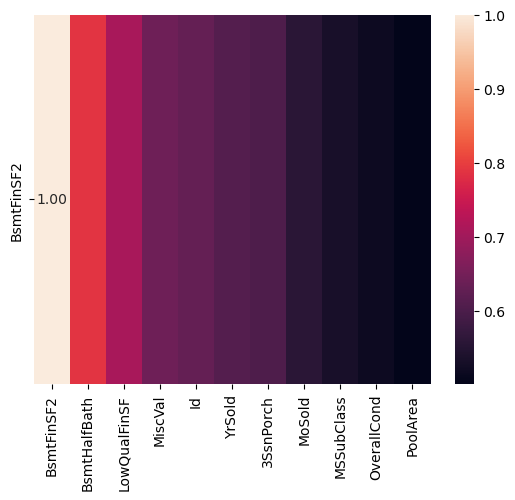

In [25]:
sales_correlation_hmn = sns.heatmap(
    cm[:1],
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=bottom_10_corr[:1].values,
    xticklabels=bottom_10_corr.values,
)

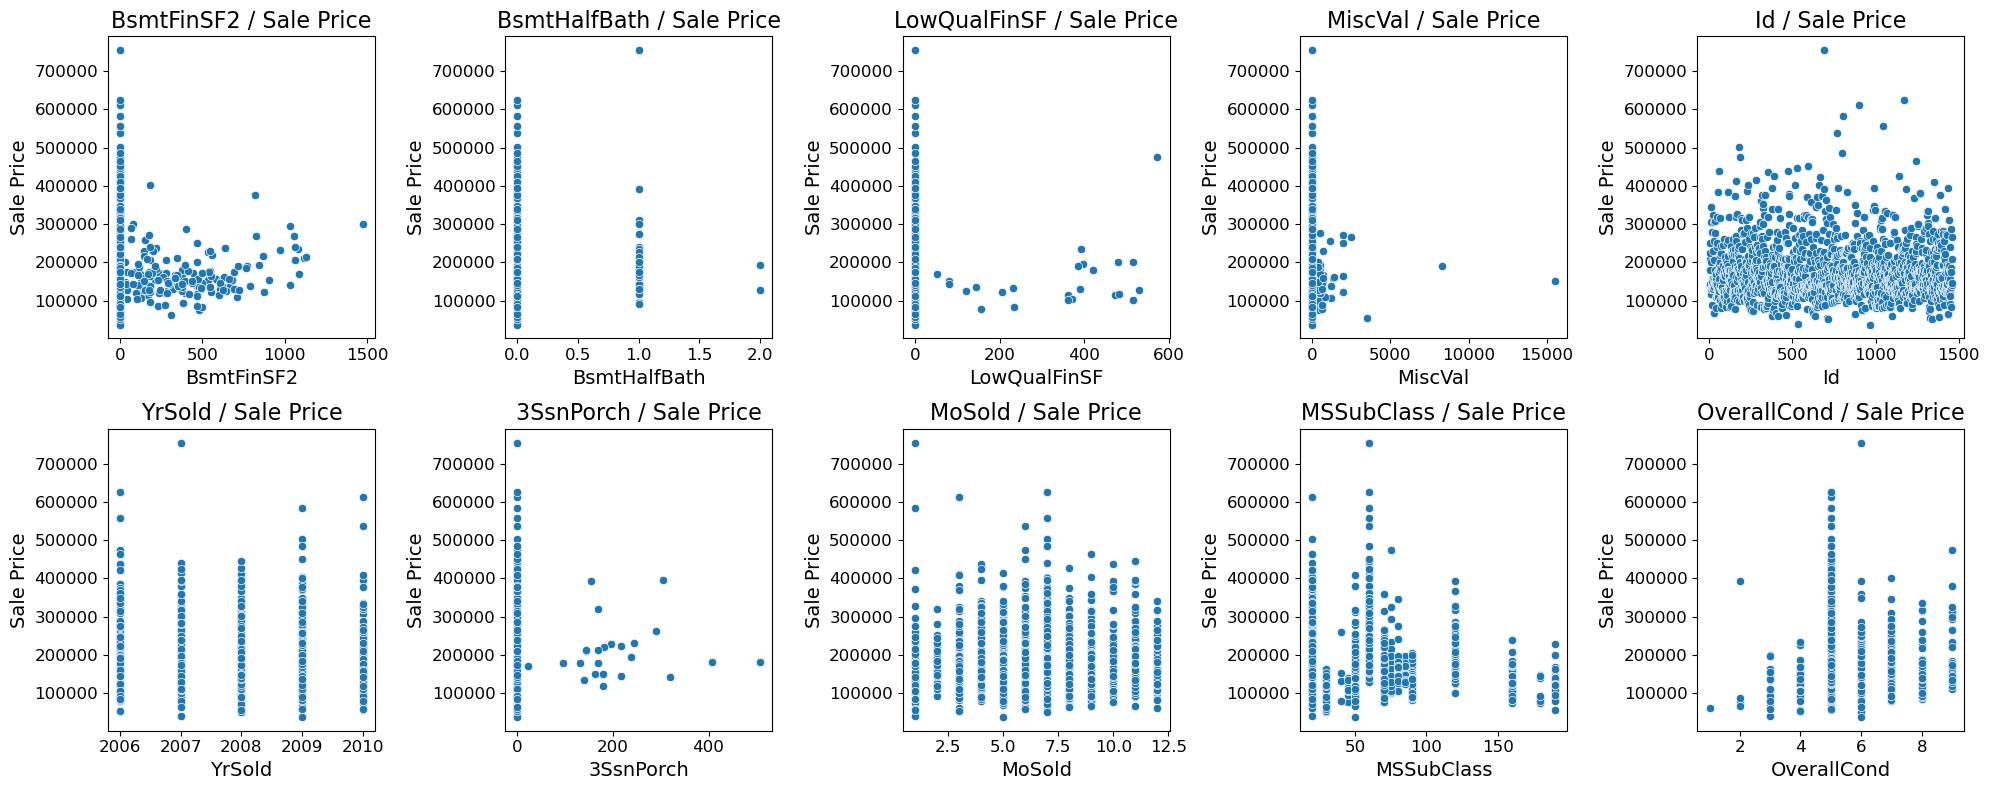

In [26]:
Negetive_FEATURES = bottom_10_corr

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axs = axs.flatten()

for i, ax in enumerate(axs):
    sns.scatterplot(x=df_house_train[Negetive_FEATURES[i]], y=df_house_train['SalePrice'], ax=ax)
    ax.set_title('{} / Sale Price'.format(Negetive_FEATURES[i]), fontsize=16)
    ax.set_xlabel('{}'.format(Negetive_FEATURES[i]), fontsize=14)
    ax.set_ylabel('Sale Price', fontsize=14)
    ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

### 3. Which features could be discarded, saving on building costs?

In [27]:
threshold = .01
lower_correlation = correlation[abs(correlation) < threshold]
print("The features could be discarded".format(threshold))
print(lower_correlation.index.tolist())


The features could be discarded
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


### 4. Can we accurately predict home values given a set of home features?

#### Building the Models

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler


In [29]:
# Define features to use in model 
Features = top_10_corr.copy().delete([0])


In [30]:
# Create copy of data set
train_df = df_house_train.copy()
# Filter to rows included in df_house_train set for train 
train_df = train_df[train_df.Id.isin(df_house_train.Id)]

# Set up Train and Validation Sets
    # test size = 20%
    # random state = 42

X_train, X_valid, y_train, y_valid = train_test_split(
    train_df[Features], train_df["SalePrice"], test_size=0.2, random_state=42
)
_, X_valid_with_id, _, _ = train_test_split(
    train_df.drop("SalePrice", axis=1),
    train_df["SalePrice"],
    test_size=0.2,
    random_state=42,
)
# Create copy of train_df
    # limit to only rows included in df_house_test for test 
test_df = df_house_train.copy()
test_df = test_df[test_df.Id.isin(df_house_train.Id)]

X_test = test_df[Features]


In [31]:
#Removed to accommodate UI. When not using, this will increase performance

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


### Cost Function

In [ ]:
from lab_utils_uni import plt_intuition, plt_stationary, plt_update_onclick, soup_bowl
plt.style.use('./deeplearning.mplstyle')

In [ ]:
plt.close('all') 
fig, ax, dyn_items = plt_stationary(x_train, y_train)
updater = plt_update_onclick(fig, ax, x_train, y_train, dyn_items)

#### TensorFlow DNN

In [32]:
import tensorflow as tf


In [33]:
tf.keras.backend.clear_session()

# Create Deep Neural Network Model 
    # Use relu to prevent vanishing gradient problem
DNNmodel = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
    ]
)
# Compile Model
    # Use mean squared error
    # Use Adam optimization with a learning rate of 0.005
DNNmodel.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.005), metrics=["mse"])

DNNmodel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________


In [34]:
# %%time

# Train for 1000 epochs
EPOCHS = 1000

# Stop model if validation mean squared error not improved for 24 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_mse", patience=25)

# Train DNN model 
history = DNNmodel.fit(
    X_train,
    y_train,
    batch_size=256,
    verbose=0,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop],
)


In [35]:
# Evaluate Model
DNNmodel.evaluate(X_valid, y_valid, verbose=0)

[1735536128.0, 1735536128.0]

In [36]:
test_df["SalePrice"] = DNNmodel.predict(X_test)
DNNdata = test_df[["Id", "SalePrice"]]
DNNdata


46/46 [==============================] - 0s 2ms/step


,Id,SalePrice
0,1,209238.703125
1,2,167813.234375
2,3,213546.203125
3,4,191448.171875
4,5,280798.625000
...,...,...
1455,1456,189721.234375
1456,1457,238575.890625
1457,1458,229505.890625
1458,1459,131578.515625


#### Linear Regression

In [37]:
from sklearn.linear_model import LinearRegression


In [38]:
LRmodel = LinearRegression()


In [39]:
LRmodel.fit(X_train, y_train)


LinearRegression()

In [40]:
print(f"Train Accuracy : {LRmodel.score(X_train,y_train)}")
print(f"Validation Accuracy : {LRmodel.score(X_valid,y_valid)}")

Train Accuracy : 0.8319485280154375
Validation Accuracy : 0.7698626967324537


In [41]:
LRdata = test_df
LRdata["SalePrice"] = LRmodel.predict(X_test)
LRdata = LRdata[["Id", "SalePrice"]]
LRdata


,Id,SalePrice
0,1,211107.463234
1,2,163594.515557
2,3,224829.211076
3,4,193268.704097
4,5,280479.143164
...,...,...
1455,1456,191422.671350
1456,1457,238432.141667
1457,1458,233238.807959
1458,1459,131644.620707


#### Random Forest Model 

In [42]:
from sklearn.ensemble import RandomForestRegressor

In [43]:
RFmodel = RandomForestRegressor(n_estimators=100)

In [44]:
RFmodel.fit(X_train,y_train)

RandomForestRegressor()

In [45]:
print(f"Train Accuracy : {RFmodel.score(X_train,y_train)}")
print(f"Validation Accuracy : {RFmodel.score(X_valid,y_valid)}")

Train Accuracy : 0.9798150696498499
Validation Accuracy : 0.8500162196981457


In [46]:
RFdata = test_df
RFdata["SalePrice"] = RFmodel.predict(X_test)
RFdata = RFdata[["Id", "SalePrice"]]
RFdata

,Id,SalePrice
0,1,204510.00
1,2,173212.90
2,3,217356.56
3,4,155576.00
4,5,266640.50
...,...,...
1455,1456,174716.00
1456,1457,208955.24
1457,1458,266210.49
1458,1459,138808.80


#### XGBoost Model

In [48]:
from xgboost import XGBRegressor

In [49]:
XGmodel = XGBRegressor(n_estimators=3000, learning_rate=0.005)

In [50]:
XGmodel.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [51]:
print(f"Train Accuracy : {XGmodel.score(X_train,y_train)}")
print(f"Validation Accuracy : {XGmodel.score(X_valid,y_valid)}")

Train Accuracy : 0.9873510440836475
Validation Accuracy : 0.87485807768259


In [52]:
XGdata = test_df
XGdata["SalePrice"] = XGmodel.predict(X_test)
XGdata = XGdata[["Id", "SalePrice"]]
XGdata


,Id,SalePrice
0,1,203130.484375
1,2,170642.000000
2,3,218508.468750
3,4,142416.843750
4,5,261849.281250
...,...,...
1455,1456,176042.281250
1456,1457,210061.375000
1457,1458,268050.531250
1458,1459,132379.562500


In [53]:
# Used for UI
import pickle
# Save the XGmodel to a file
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(XGmodel, file)

#### Ensemble: Stacking

In [54]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Define estimators
estimator_list = [
    # ('DNN', DNNmodel) # Need to Fix
    ('LR',LRmodel),
    ('RF',RFmodel),
    ('XGB',XGmodel)]

# Build stack model
stack_model = StackingRegressor(
    estimators=estimator_list, final_estimator=RidgeCV()
)

# Train stacked model
stack_model.fit(X_train, y_train)

# Make predictions
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_valid)


In [55]:
print(f"Train Accuracy : {stack_model.score(X_train,y_train)}")
print(f"Validation Accuracy : {stack_model.score(X_valid,y_valid)}")

Train Accuracy : 0.9641029835620359
Validation Accuracy : 0.8587790707371249


In [56]:
ENSdata = test_df
ENSdata["SalePrice"] = stack_model.predict(X_test)
ENSdata = ENSdata[["Id", "SalePrice"]]
ENSdata

,Id,SalePrice
0,1,205808.913121
1,2,169355.684062
2,3,221250.554075
3,4,160379.884856
4,5,270760.164336
...,...,...
1455,1456,180916.805895
1456,1457,219771.171298
1457,1458,258416.032407
1458,1459,131932.907604


### 5. Which model predicts home values most accurately?

#### Compare Models

In [58]:
# Empty dict for model comparison
model_comp ={}

# Add model scores to dict
model_comp['LR'] = [LRmodel.score(X_train,y_train), LRmodel.score(X_valid,y_valid)]
model_comp['RF'] = [RFmodel.score(X_train,y_train), RFmodel.score(X_valid,y_valid)]
model_comp['XGB'] = [XGmodel.score(X_train,y_train), XGmodel.score(X_valid,y_valid)]
model_comp['Stack'] = [stack_model.score(X_train,y_train), stack_model.score(X_valid,y_valid)]

# Build Table
model_comp = pd.DataFrame.from_dict(model_comp).T
model_comp.columns = ['Train Accuracy', 'Validation Accuracy']
model_comp = model_comp.sort_values('Validation Accuracy', ascending=False)
model_comp.style.background_gradient(cmap='Greens')

,Train Accuracy,Validation Accuracy
XGB,0.987351,0.874858
Stack,0.964103,0.858779
RF,0.979815,0.850016
LR,0.831949,0.769863


In [59]:
# Compare prediction to valid
Compare_df = pd.DataFrame(
    data={
        "Id": X_valid_with_id["Id"],
        "DNN_Predicted_Price": DNNmodel.predict(X_valid).ravel(),
        "LR_Predicted_Price": LRmodel.predict(X_valid).ravel(),
        "RF_Predicted_Price": RFmodel.predict(X_valid).ravel(),
        "XG_Predicted_Price": XGmodel.predict(X_valid).ravel(),
        "Ensemble_Predicted_Price": stack_model.predict(X_valid).ravel(),
        "True_Price": y_valid,
    }
)

10/10 [==============================] - 0s 2ms/step


c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

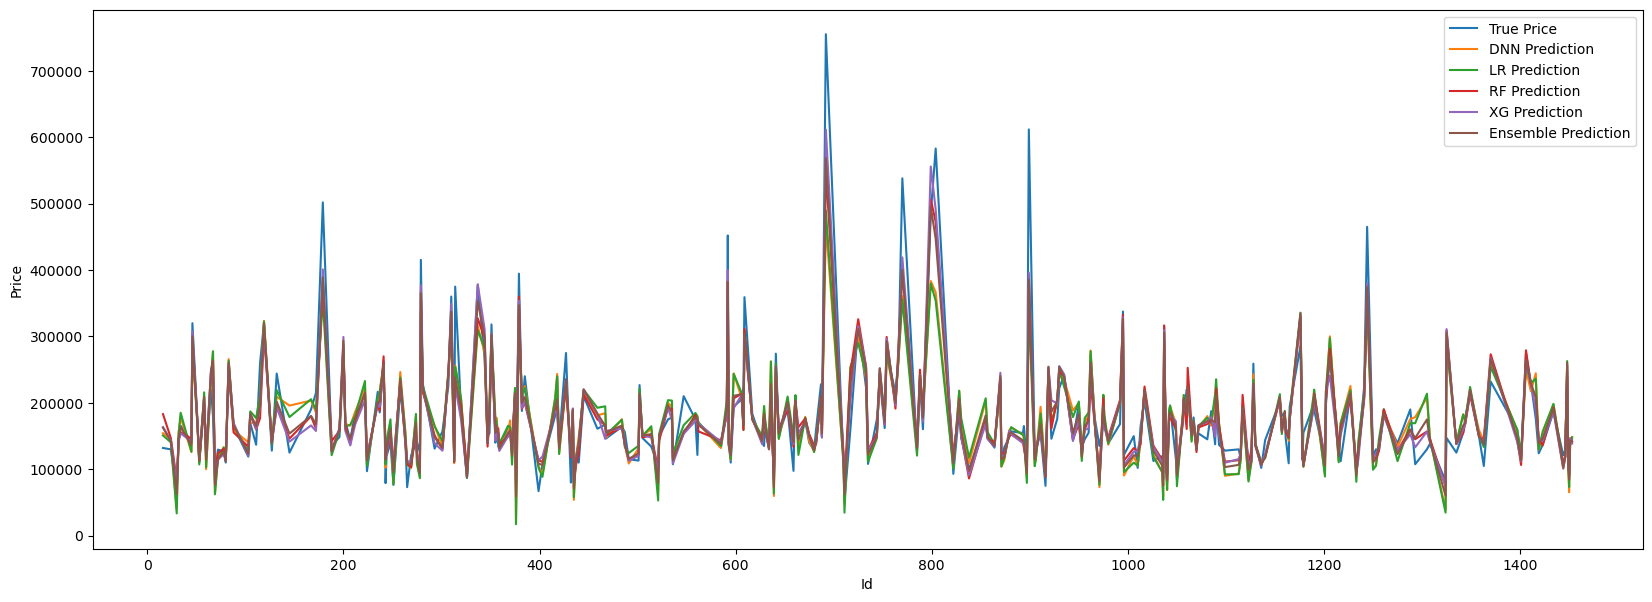

In [60]:
plt.figure(figsize=(20, 7))
ax = sns.lineplot(
    data=Compare_df, x="Id", y="True_Price", label="True Price"
)
sns.lineplot(
    data=Compare_df, x="Id", y="DNN_Predicted_Price", label="DNN Prediction", ax=ax
)
sns.lineplot(
    data=Compare_df, x="Id", y="LR_Predicted_Price", label="LR Prediction", ax=ax
)
sns.lineplot(
    data=Compare_df, x="Id", y="RF_Predicted_Price", label="RF Prediction", ax=ax
)
sns.lineplot(
    data=Compare_df, x="Id", y="XG_Predicted_Price", label="XG Prediction", ax=ax
)
sns.lineplot(
    data=Compare_df, x="Id", y="Ensemble_Predicted_Price", label="Ensemble Prediction", ax=ax
)
ax.set_ylabel("Price")
plt.show()

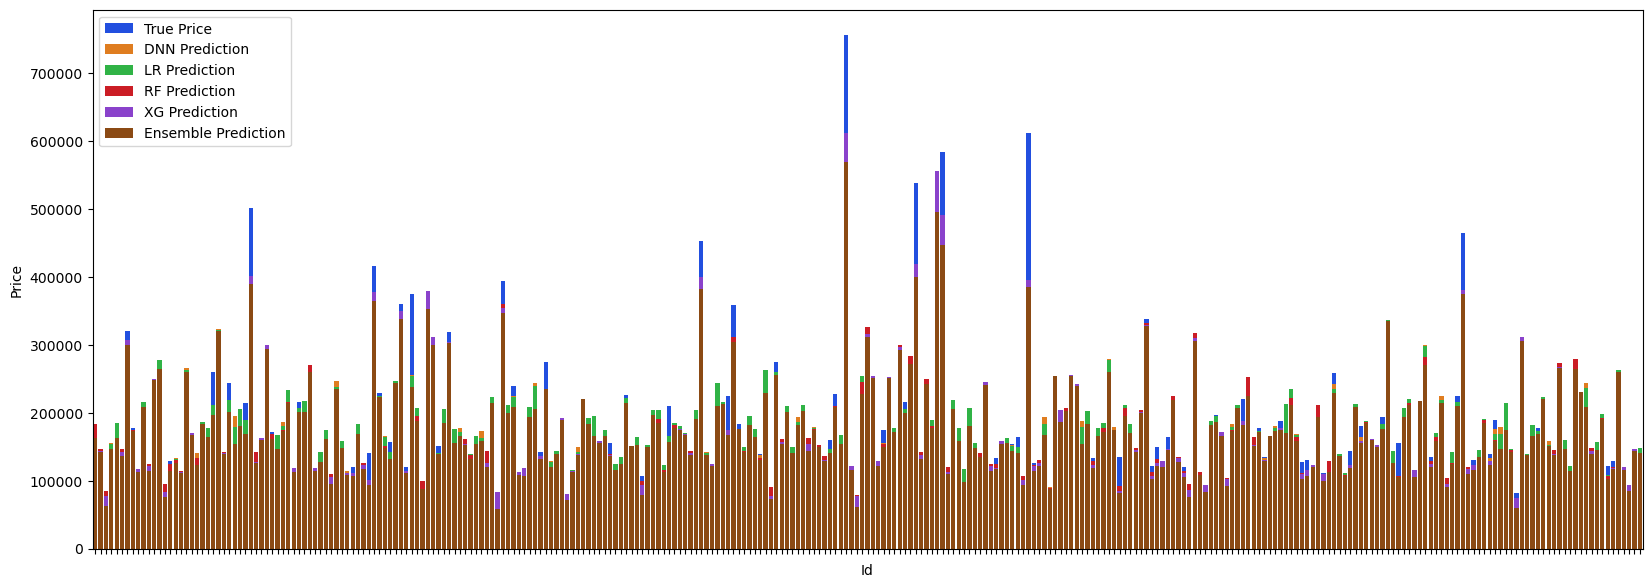

In [61]:
palette = sns.color_palette("bright", n_colors=6)

plt.figure(figsize=(20, 7))
ax = sns.barplot(
    data=Compare_df, x="Id", y="True_Price", label="True Price", color=palette[0]
)
sns.barplot(
    data=Compare_df, x="Id", y="DNN_Predicted_Price", label="DNN Prediction", color=palette[1], ax=ax
)
sns.barplot(
    data=Compare_df, x="Id", y="LR_Predicted_Price", label="LR Prediction", color=palette[2], ax=ax
)
sns.barplot(
    data=Compare_df, x="Id", y="RF_Predicted_Price", label="RF Prediction", color=palette[3], ax=ax
)
sns.barplot(
    data=Compare_df, x="Id", y="XG_Predicted_Price", label="XG Prediction", color=palette[4], ax=ax
)
sns.barplot(
    data=Compare_df, x="Id", y="Ensemble_Predicted_Price", label="Ensemble Prediction", color=palette[5], ax=ax
)
ax.set_ylabel("Price")
plt.legend(loc="upper left")
ax.set_xticklabels(labels=[])
plt.show()

c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicho\.conda\envs\tf\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

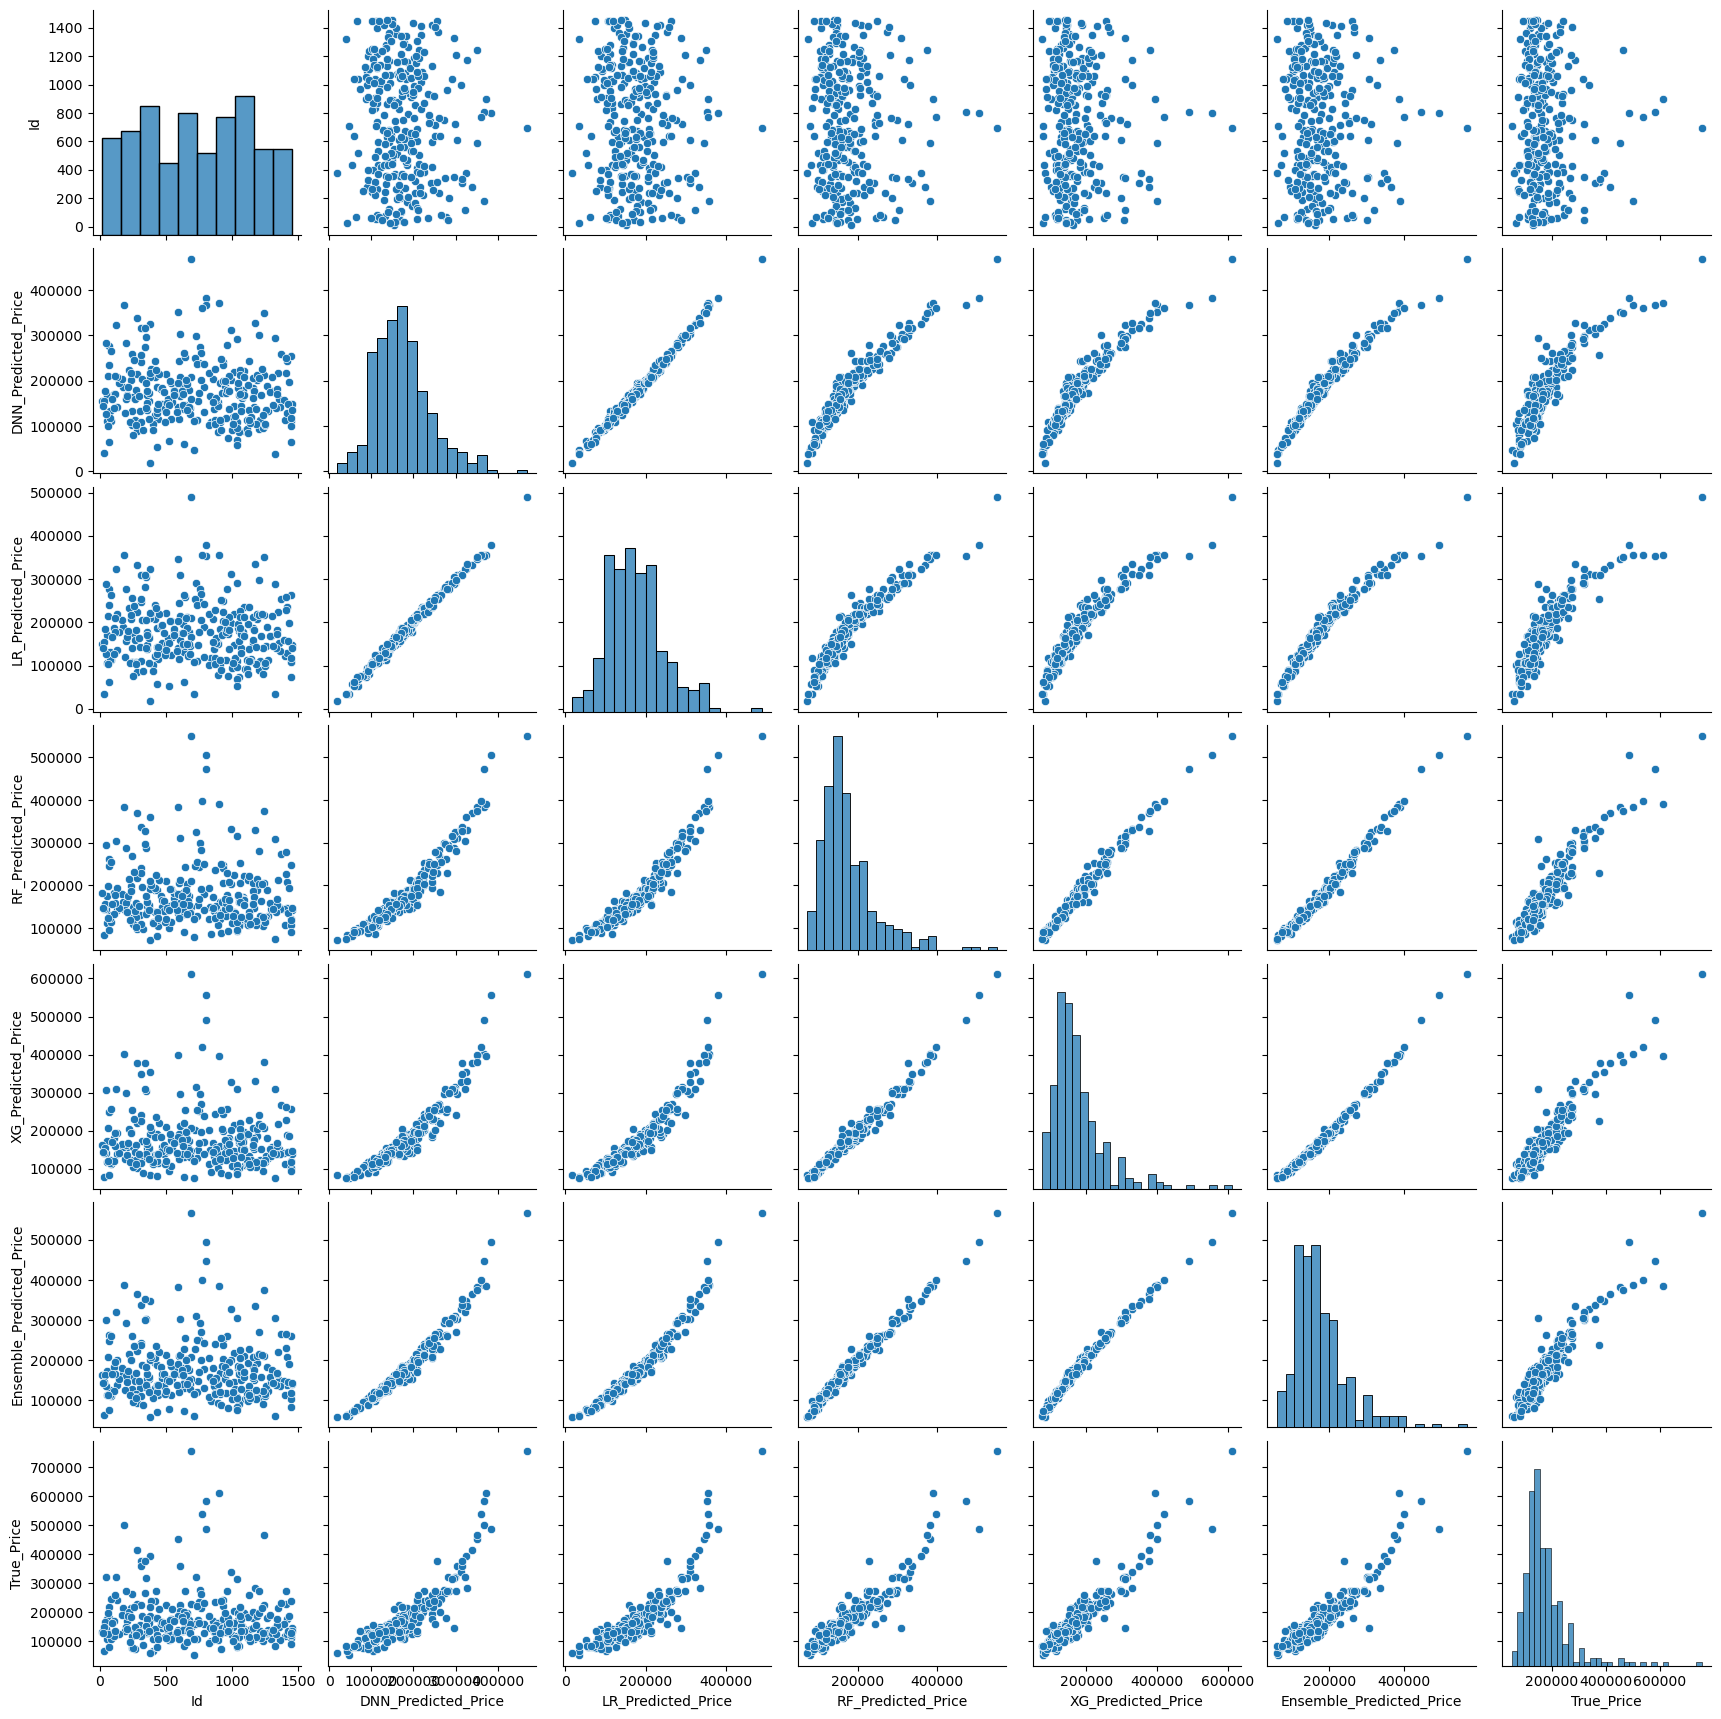

In [62]:
sns.pairplot(Compare_df)

In [63]:
Compare_df.head()


,Id,DNN_Predicted_Price,LR_Predicted_Price,RF_Predicted_Price,XG_Predicted_Price,Ensemble_Predicted_Price,True_Price
415,416,207735.640625,207729.934294,189000.710,188365.843750,194422.632887,181134
608,609,303469.687500,309982.095427,311164.740,297313.468750,304068.893784,359100
560,561,179040.687500,180078.054486,169688.000,175855.437500,174997.359519,121500
66,67,276712.687500,277707.319437,262749.660,249448.265625,263840.300209,180000
381,382,207295.109375,210651.632377,191137.275,192482.234375,199824.321918,187750
